## Demo: Test-Time Augmentation for Model-Brain Similarity
This demo guides readers through a concise yet comprehensive pipeline demonstrating how Test-Time Augmentation (TTA) can enhance model-brain similarity, using common packages and minimal computational resources.
- For more information about the code repo, please check [the repository](https://github.com/BonnerLab/diffuse-encoder).
- For more information about the project, please check the paper [Neural networks and brains share the gist but not the details: a surprising benefit of image ensembles for encoding models of visual cortex](https://openreview.net/forum?id=DtEeVWfgNM&noteId=DtEeVWfgNM).


In [1]:
# Load packages
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

### Get Familiar with the Data

The data prepared for Test-Time Augmentation (TTA) contains the following elements:

- **Original Image:** The image shown to human subjects. Here, we use one picture from the Natural Scene Dataset.  
  - **Neural Responsess:** Responses of regions of interest (ROIs) in the visual cortex when human subjects view the original image. In this case, the ROI is the ventral visual stream of the first subject.  
  - **Model Representations:** Model-derived abstractions for a specific model layer given the original image. Here, the model layer is the third layer of AlexNet.

- **Augmented Images:** Images used for TTA, not shown to human subjects. Here, five images are generated based on human captions. To understand more about image generations, please refer to notebooks/tutorial_with_diffusions.ipynb for more information
  - **Augmented Model Representations:** Averaged model abstractions for the same model layer, computed from the augmented images. Again, this corresponds to the third layer of AlexNet.

The format for demo_data would be:

```
demo_data/
├── original/
│   └── 605.jpg
└── augmentation/
    └── 605/
        ├── figure_1.jpg
        ├── figure_2.jpg
        ├── figure_3.jpg
        ├── figure_4.jpg
        └── figure_5.jpg
        └── ....
└── response/
    └── ventral_visual_stream.csv
```

#### Show sample image

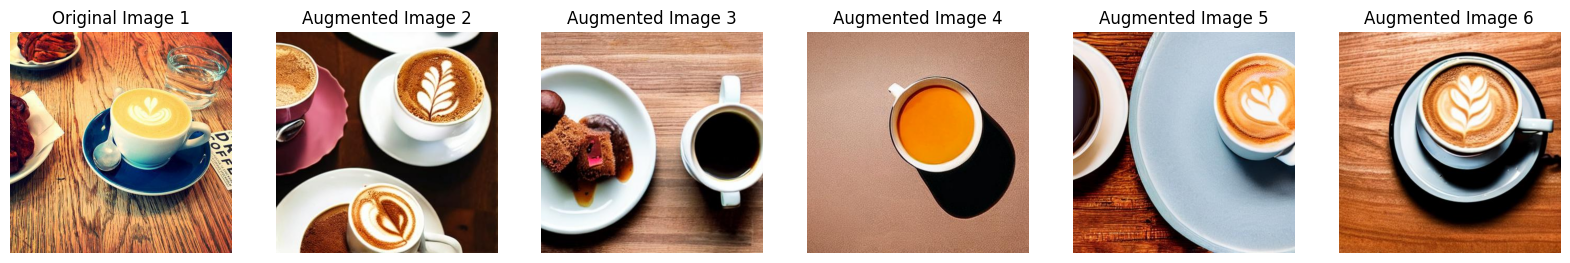

In [2]:
# Show one sample image
# Set the image_id
image_id = 605

# Show first five augmented images
fig, axes = plt.subplots(1, 6, figsize=(20,4))
for i in range(6):
    if i == 0:
        img = mpimg.imread(f'demo_data/original/{image_id}.jpg')
        axes[i].imshow(img)
        axes[i].set_title(f'Original Image {i+1}')
    else:
        img = mpimg.imread(f'demo_data/augmentation/605/image_{i+1}.jpg')
        axes[i].imshow(img)
        axes[i].set_title(f'Augmented Image {i+1}')
    axes[i].axis('off')
plt.show()

#### Load the response of ventral visual stream

In [3]:
# load the responses
neural_response = pd.read_csv('demo_data/response/ventral_visual_stream.csv',index_col=0)

In [4]:
# 
neural_response['605']

3      -0.114088
4      -0.110522
6      -0.066276
7      -0.249092
8      -0.122133
          ...   
7596    0.882167
7597    1.257242
7599   -1.437957
7600    1.482676
7602    0.473303
Name: 605, Length: 3221, dtype: float64

#### Load the model activation

In [5]:
def extract_reduced_Alexnet_features(image_path, layer_index=6, n_components=1024, random_state=42):
    """
    Extract a 1D feature vector from a specified layer of AlexNet and reduce its dimensionality using Sparse Random Projection.

    Args:
        image_path (str): Path to the input image.
        layer_index (int): Index of the layer in alexnet.features to extract activations from.
        n_components (int): Target dimensionality after projection.
        random_state (int): Random seed for SRP.

    Returns:
        np.ndarray: 1D projected feature vector.
    """
    # Load pretrained AlexNet
    alexnet = models.alexnet(pretrained=True)
    alexnet.eval()

    # Register hook to capture activations
    activation = {}
    def hook_fn(module, input, output):
        activation["features"] = output.detach()

    alexnet.features[layer_index].register_forward_hook(hook_fn)

    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        _ = alexnet(input_tensor)

    # Flatten the extracted activation
    flat = activation["features"].view(1, -1).cpu().numpy()

    # Apply Sparse Random Projection
    srp = SparseRandomProjection(n_components=n_components, random_state=random_state)
    projected = srp.fit_transform(flat)

    return projected.squeeze()  # Shape: (n_components,)

In [6]:
# load the average augmanted_model_representation
model_representation = extract_reduced_Alexnet_features(f'demo_data/original/{image_id}.jpg', layer_index=6)
# load the average augmanted_model_representation from 40 augmented images
augmentated_model_representation = np.array([extract_reduced_Alexnet_features(f'demo_data/augmentation/605/image_{i+1}.jpg',layer_index=6) for i in range(41)]).mean(0)

### Encoding procedure 
When you get famliar with the data, we could do the encoding procedure based on Ridge Regression with Leave-One-Out Cross-Validation (LOOCV). 

If you really want to re-run regression by yourself, please set up your demo_data in a correct way which means that you need to save NSD shared1000 images in the folder *original* and the corresponding augemnated images in the folder *augmentation* with correct format. It would need some time to extract features.
To make things easier, we load the extracted features directly in the form of torch tensor.

In [ ]:
# If you want to re-run the feature-extraction, please uncomment codes below. Take several hours or days to run
# For main implementations, the issue of speed is why packages such as bonner-libraries and DeepJuice are utilized
'''
def feature_extraction(original_dir, augmentation_dir, save_dir, layer_index=6, n_augments=40, n_components = 5920):
    """
    Extract and save model representations for all images into a single .npz file.

    Args:
        original_dir (str): Folder with original images (e.g., 'original/605.jpg').
        augmentation_dir (str): Folder with augmentation subfolders (e.g., 'augmentation/605/image_1.jpg').
        save_path (str): File path to save the .npz archive.
        layer_index (int): Layer index for AlexNet feature extraction.
        n_augments (int): Number of augmentations per image.
    """
    original_reps = {}
    augmented_avg_reps = {}

    image_files = [f for f in os.listdir(original_dir) if f.endswith('.jpg')]

    for fname in tqdm(image_files, desc="Extracting features"):
        image_id = os.path.splitext(fname)[0]
        orig_path = os.path.join(original_dir, fname)
        orig_vec = extract_reduced_Alexnet_features(orig_path, layer_index=layer_index,n_components=n_components)
        original_reps[image_id] = orig_vec

        aug_dir = os.path.join(augmentation_dir, image_id)
        aug_vecs = []
        for i in range(n_augments + 1):
            aug_path = os.path.join(aug_dir, f'image_{i+1}.jpg')
            if os.path.exists(aug_path):
                aug_vec = extract_reduced_Alexnet_features(aug_path, layer_index=layer_index,n_components=n_components)
                aug_vecs.append(aug_vec)

        if aug_vecs:
            avg_aug_vec = np.mean(aug_vecs, axis=0)
            augmented_avg_reps[image_id] = avg_aug_vec
        else:
            print(f"[Warning] No augmentations found for {image_id}")
            
     # Save all as one .npz
    np.savez(save_dir, original=original_reps, augmented_avg=augmented_avg_reps)
    
    return original_reps, augmented_avg_reps
    
    

# Please substitute this with the folder name to save original images
original_dir = '/home/yrong12/project/diffuse-encoder/DeepJuiceDev/juicyfruits/nsd_subset/stimulus/shared1000'
# Please substitute this with the folder name to save original images
augmentation_dir = '/data/yrong12/experiment_3/sd-1-5/Positive_Text/s=1_g=7.5'

# After you attain the format of dic, you could transform them to be torch tensor with the format 1000 x 5920 for further analysis
original_reps, augmented_avg_reps = feature_extraction(
    original_dir=original_dir ,
    augmentation_dir=augmentation_dir,
    save_dir='demo_data/features',
    layer_index=6,
    n_augments=40
)
'''

'\ndef feature_extraction(original_dir, augmentation_dir, save_dir, layer_index=6, n_augments=40, n_components = 5920):\n    """\n    Extract and save model representations for all images into a single .npz file.\n\n    Args:\n        original_dir (str): Folder with original images (e.g., \'original/605.jpg\').\n        augmentation_dir (str): Folder with augmentation subfolders (e.g., \'augmentation/605/image_1.jpg\').\n        save_path (str): File path to save the .npz archive.\n        layer_index (int): Layer index for AlexNet feature extraction.\n        n_augments (int): Number of augmentations per image.\n    """\n    original_reps = {}\n    augmented_avg_reps = {}\n\n    image_files = [f for f in os.listdir(original_dir) if f.endswith(\'.jpg\')]\n\n    for fname in tqdm(image_files, desc="Extracting features"):\n        image_id = os.path.splitext(fname)[0]\n        orig_path = os.path.join(original_dir, fname)\n        orig_vec = extract_reduced_Alexnet_features(orig_path, la

In [31]:
class RidgeLOOCV:
    def __init__(self, alphas=None, scale_X=True, device='cpu'):
        self.alphas = alphas if alphas is not None else np.logspace(-1, 5, 7)
        self.scale_X = scale_X
        self.device = device

        self.best_alpha = None
        self.weights = None
        self.scaler = None  # Save for transforming new inputs

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device)

        if self.scale_X:
            self.scaler = StandardScaler()
            X_np = X.cpu().numpy()
            X = torch.tensor(self.scaler.fit_transform(X_np), dtype=torch.float32, device=self.device)

        n = X.shape[0]
        cv_errors = []

        for alpha in self.alphas:
            errors = []
            for i in range(n):
                X_train = torch.cat([X[:i], X[i+1:]], dim=0)
                y_train = torch.cat([y[:i], y[i+1:]], dim=0)
                X_val = X[i].unsqueeze(0)
                y_val = y[i].unsqueeze(0)

                I = torch.eye(X_train.shape[1], device=self.device)
                XtX = X_train.T @ X_train
                Xty = X_train.T @ y_train
                w = torch.linalg.solve(XtX + alpha * I, Xty)

                y_pred = X_val @ w
                error = torch.mean((y_val - y_pred).pow(2)).item()
                errors.append(error)

            cv_errors.append(np.mean(errors))

        best_idx = int(np.argmin(cv_errors))
        self.best_alpha = self.alphas[best_idx]

        # Train on full data
        I = torch.eye(X.shape[1], device=self.device)
        XtX = X.T @ X
        Xty = X.T @ y
        self.weights = torch.linalg.solve(XtX + self.best_alpha * I, Xty)

    def predict(self, X_new):
        X_new = np.array(X_new, dtype=np.float32)
        if self.scale_X and self.scaler is not None:
            X_new = self.scaler.transform(X_new)
        X_new = torch.tensor(X_new, dtype=torch.float32, device=self.device)
        return (X_new @ self.weights).cpu().numpy()

In [ ]:
# Access the model representations from file
load_path = 'demo_data/features/tensors.pt'
data = torch.load(load_path)

original_representation= data['original_representation']
augmented_representation = data['augmented_representation']

X_original = {'train': original_representation[0::2,], 'test': original_representation[1::2,:]} # splithalf
X_augmented = {'train': augmented_representation[0::2,], 'test': augmented_representation[1::2,:]} # splithalf

In [50]:
# Access the neural response from file
y = torch.tensor(neural_response.drop(columns=['voxel_id']).values, dtype=torch.float32).T
y = {'train': y[0::2,], 'test': y[1::2,:]} # splithalf

In [51]:
model_original = RidgeLOOCV(alphas=np.logspace(-1, 5, 7), scale_X=True, device='cuda')
model_original.fit(X_original['train'], y['train'])

model_augmented = RidgeLOOCV(alphas=np.logspace(-1, 5, 7), scale_X=True, device='cuda')
model_augmented.fit(X_augmented['train'], y['train'])

In [52]:
y_original_pred = model_original.predict(X_original['test'])
y_augmented_pred = model_augmented.predict(X_augmented['test'])

In [53]:
def pearson_corr(x, y):
    """
    Compute Pearson correlation for each feature column between two numpy arrays x and y.
    x, y: numpy arrays of shape (n_samples, n_features)
    Returns: numpy array of shape (n_features,) with correlation coefficients
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    x_mean = np.mean(x, axis=0)
    y_mean = np.mean(y, axis=0)
    
    xm = x - x_mean
    ym = y - y_mean
    
    r_num = np.sum(xm * ym, axis=0)
    r_den = np.sqrt(np.sum(xm ** 2, axis=0)) * np.sqrt(np.sum(ym ** 2, axis=0))
    
    r = r_num / r_den
    return r


In [54]:
print('The encoding score for original image would be:', pearson_corr(y_original_pred,y['test']).mean())
print('The encoding score for augmented images would be:', pearson_corr(y_augmented_pred,y['test']).mean())

The encoding score for original image would be: 0.05868809
The encoding score for augmented images would be: 0.08787791
